In [1]:
# https://www.kaggle.com/c/whale-categorization-playground

path = '/notebook/kaggle/'
HOME_DIR = path + 'data/whale_categorization/'
DATA_DIR = HOME_DIR # + 'sample/'
RESULTS_DIR = DATA_DIR + 'results/'
TRAIN_DIR = DATA_DIR + 'train/'
VAL_DIR = DATA_DIR + 'valid/'
TEST_DIR = DATA_DIR + 'test/'

In [2]:
!echo $CUDA_VISIBLE_DEVICES # Should be 0

0


In [40]:
import json
import os
import random
from PIL import Image
#import os, json, glob, shutil
# from skimage.transform import resize
# from skimage.io import imsave, imread
import numpy as np
import pandas as pd
# from matplotlib import pyplot as plt
# import math
import matplotlib.pylab as plt

# from keras.models import Sequential, Model
# from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
# from keras.optimizers import SGD, RMSprop, Adam, Nadam
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
# from keras.regularizers import l2, l1
# from keras import backend as K
# from keras.layers.core import Flatten, Dense, Dropout, Lambda
# from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
# from keras.applications import VGG19, ResNet50
# from keras.applications.xception import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

%matplotlib inline

In [4]:
with open(path+'kaggle.txt') as json_file:  
    kg_data = json.load(json_file)
    
username = kg_data['username']
password = kg_data['password']

!kg config -g -u $username -p $password -c 'whale-categorization-playground'

#%cd $HOME_DIR
#!kg download
#%cd $path

# import zipfile
# zip = zipfile.ZipFile(HOME_DIR+'test.zip')
# zip.extractall(HOME_DIR)

# zip = zipfile.ZipFile(HOME_DIR+'train.zip')
# zip.extractall(HOME_DIR)

### Data set-up

In [5]:
# Load training labels
labels = pd.read_csv(HOME_DIR+'train.csv')
imageId_dict = dict(zip(labels['Image'], labels['Id']))

# Count files in training vs. validation sets
train_files = os.listdir(TRAIN_DIR) # Get list of image files
print('# of training images: '+str(len(train_files)))
val_files = os.listdir(VAL_DIR)
print('# of validation images: '+str(len(val_files)))
test_files = os.listdir(TEST_DIR)
print('# of test images: '+str(len(test_files)))

trainId_dict = dict(zip(train_files,[imageId_dict[im] for im in train_files]))

# of training images: 8373
# of validation images: 1477
# of test images: 15610


#### Enforce training/validation split
- Split training and validation data such that a percentage of images in the validation set are not in the training set

In [6]:
# Enforce train/validate split
validation_split = 0.15

# Check difference between number of files in training v. validation set
target_val_size = int((len(train_files)+len(val_files))*validation_split)
split_diff = target_val_size-len(val_files)

if (split_diff>0):
    
    print('Moving '+str(split_diff)+' files')
    
    for file_name in random.sample(train_files, split_diff):
        full_file_name = os.path.join(TRAIN_DIR, file_name)

        if (os.path.isfile(full_file_name)):
            %mv $full_file_name $VAL_DIR
            
    # Count files in each set again (after train/validate split above)
    train_files = os.listdir(TRAIN_DIR) # Get list of image files
    print('# of training images: '+str(len(train_files)))
    val_files = os.listdir(VAL_DIR)
    print('# of validation images: '+str(len(val_files)))        

In [38]:
# Import images with a resizing and a black and white conversion
im_sz = 64 # New image size

def ImportImage(filename):
    img = Image.open(filename).convert("LA").resize((im_sz, im_sz))
    return np.array(img)[:,:,0]

x_train = np.array([ImportImage(TRAIN_DIR + img_name) for img_name in train_files]) # Training data
#x_valid = np.array([ImportImage(VAL_DIR + img_name) for img_name in val_files]) # Validation data
#x_test = np.array([ImportImage(TEST_DIR + img_name) for img_name in test_files]) # Validation data

In [75]:
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform(x)
        return self.ohe.fit_transform(features.reshape(-1,1))
    def transform(self, x):
        return self.ohe.transform(self.la.transform(x.reshape(-1,1)))
    def inverse_tranform(self, x):
        return self.le.inverse_transform(self.ohe.inverse_tranform(x))
    def inverse_labels(self, x):
        return self.le.inverse_transform(x)

y = list(map(imageId_dict.get, train_files))
lohe = LabelOneHotEncoder()
y_cat = lohe.fit_transform(y)
print(y_cat[:15])

  (0, 2127)	1.0
  (1, 777)	1.0
  (2, 1791)	1.0
  (3, 1381)	1.0
  (4, 1553)	1.0
  (5, 2216)	1.0
  (6, 2961)	1.0
  (7, 3435)	1.0
  (8, 3198)	1.0
  (9, 3405)	1.0
  (10, 2315)	1.0
  (11, 2097)	1.0
  (12, 3390)	1.0
  (13, 328)	1.0
  (14, 676)	1.0


In [7]:
# Instantiate objects
ohe = OneHotEncoder()
le = LabelEncoder()
    
def train_encoder(filename_list):
    '''Uses a composition of a LabelEncoder and OneHotEncoder to one hot encode the target labels'''
    y = list(map(trainId_dict.get, filename_list))
    #y = list(map(imageId_dict.get, filename_list))
    features = le.fit_transform(y)
    features = features.reshape(-1,1)
    y_encoded = ohe.fit_transform(features)
    return(y_encoded)

train_encoded = train_encoder(train_files)

#val_encoded = train_encoder(val_files)

# test_encoded = train_encoder(test_files)
#y_encoded.toarray()[0]

In [17]:
labels['Id'].head()

0    w_e15442c
1    w_1287fbc
2    w_da2efe0
3    w_19e5482
4    w_f22f3e3
Name: Id, dtype: object

In [19]:
trainId_dict.values()[:5]

['w_75378d3', 'w_2dae424', 'w_219e33c', 'w_da0b8b5', 'w_97666c8']

In [32]:
#constructing class weights
WeightFunction = lambda x : 1./x**0.75
ClassLabel2Index = lambda x : le.inverse_tranform([[x]])

# Get counts for each label (i.e. whale)
CountDict = dict(pd.Series(trainId_dict.values()).value_counts())
class_weight_dic = { le.transform( [image_name])[0] : WeightFunction(count) for image_name, count in CountDict.items()}
del CountDict

In [29]:
??le.inverse_transform()

In [35]:
CountDict = dict(pd.Series(trainId_dict.values()).value_counts())
print({ image_name : WeightFunction(count) for image_name, count in CountDict.items()})

{'w_896023f': 0.59460355750136051, 'w_118d911': 1.0, 'w_b34793e': 0.26084743001221455, 'w_d4bc10d': 1.0, 'w_4de83f9': 1.0, 'w_4a38a9f': 0.59460355750136051, 'w_db3621e': 0.43869133765083085, 'w_dd086b2': 1.0, 'w_db9e932': 0.59460355750136051, 'w_62ca7c8': 0.43869133765083085, 'w_2482b4a': 0.59460355750136051, 'w_83034c7': 1.0, 'w_c90feaa': 0.59460355750136051, 'w_7185713': 0.59460355750136051, 'w_3ce788a': 1.0, 'w_e5893cb': 1.0, 'w_3d0bc7a': 0.17782794100389226, 'w_bd43538': 1.0, 'w_8fac7da': 0.59460355750136051, 'w_a29719a': 1.0, 'w_dbb786d': 1.0, 'w_6be343c': 1.0, 'w_4f248f3': 0.43869133765083085, 'w_38b1edd': 0.59460355750136051, 'w_70e49bc': 1.0, 'w_5b99089': 0.23236808024254083, 'w_ffb4e3d': 0.59460355750136051, 'w_01f9086': 1.0, 'w_54cd8e0': 1.0, 'w_b678944': 0.19245008972987526, 'w_aae82f8': 0.29906975624424409, 'w_30cf2ca': 1.0, 'w_fac9864': 1.0, 'w_d94db94': 0.43869133765083085, 'w_8867074': 0.21022410381342865, 'w_759b647': 0.43869133765083085, 'w_17a0832': 1.0, 'w_e10dff3': 

In [33]:
class_weight_dic

{0: 0.0075013540884303559,
 1: 0.43869133765083085,
 2: 1.0,
 3: 0.59460355750136051,
 4: 1.0,
 5: 1.0,
 6: 0.59460355750136051,
 7: 1.0,
 8: 0.59460355750136051,
 9: 0.59460355750136051,
 10: 1.0,
 11: 0.59460355750136051,
 12: 1.0,
 13: 0.59460355750136051,
 14: 1.0,
 15: 0.59460355750136051,
 16: 0.59460355750136051,
 17: 1.0,
 18: 1.0,
 19: 1.0,
 20: 1.0,
 21: 1.0,
 22: 1.0,
 23: 1.0,
 24: 1.0,
 25: 1.0,
 26: 0.59460355750136051,
 27: 1.0,
 28: 1.0,
 29: 1.0,
 30: 0.43869133765083085,
 31: 1.0,
 32: 1.0,
 33: 0.59460355750136051,
 34: 0.59460355750136051,
 35: 1.0,
 36: 1.0,
 37: 1.0,
 38: 0.59460355750136051,
 39: 1.0,
 40: 1.0,
 41: 1.0,
 42: 1.0,
 43: 0.59460355750136051,
 44: 0.59460355750136051,
 45: 1.0,
 46: 1.0,
 47: 0.59460355750136051,
 48: 0.59460355750136051,
 49: 0.43869133765083085,
 50: 0.59460355750136051,
 51: 0.43869133765083085,
 52: 1.0,
 53: 0.43869133765083085,
 54: 1.0,
 55: 0.23236808024254083,
 56: 1.0,
 57: 0.59460355750136051,
 58: 1.0,
 59: 0.59460355750

Visualize images

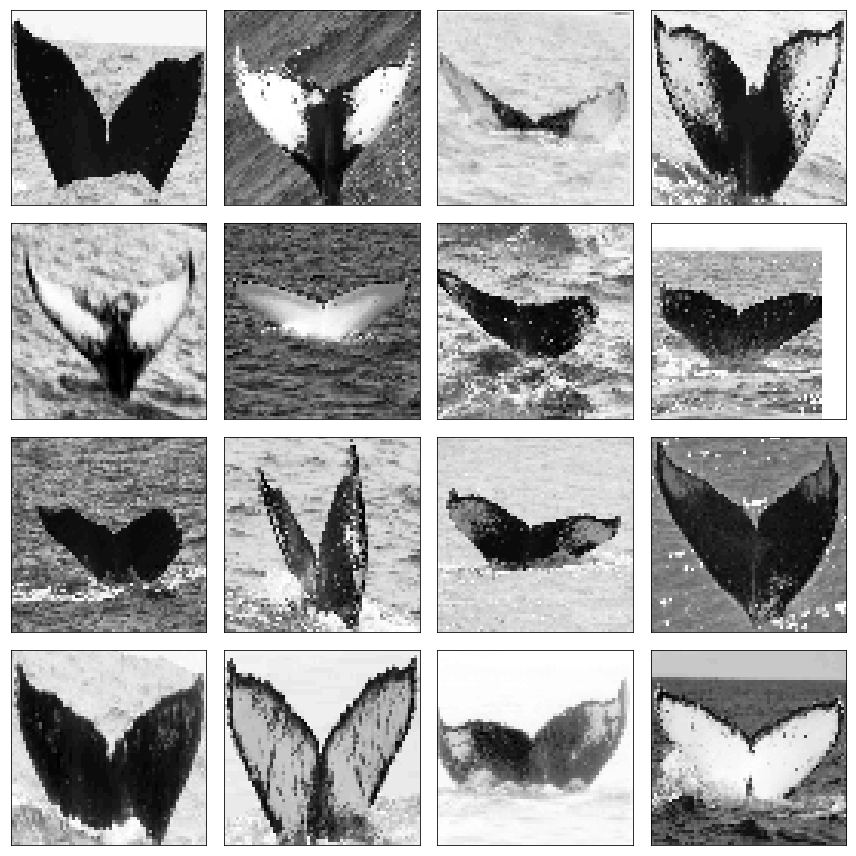

In [41]:
def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    
# Plot training images after resizing and BW conversion
plotImages(x_train)